### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [22]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
6,NSW7,1,23,12,1,0,0,0,0.000,0.000,0.0000
301,PSID117,0,23,12,0,0,1,0,14347.710,3482.177,3818.4450
612,PSID428,0,32,5,1,0,1,1,0.000,0.000,187.6713
96,NSW97,1,18,9,1,0,0,1,0.000,0.000,4482.8450
584,PSID400,0,37,8,1,0,0,1,0.000,0.000,648.7220
175,NSW176,1,28,11,1,0,0,1,1929.029,6871.856,0.0000
386,PSID202,0,20,9,0,1,1,1,0.000,1283.661,0.0000
151,NSW152,1,24,12,1,0,0,0,13765.750,2842.764,6167.6810
573,PSID389,0,18,11,1,0,0,1,0.000,0.000,7146.2860
388,PSID204,0,45,12,0,0,1,0,16559.720,1265.758,7987.1120


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

Treated:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


---------------------------------


Control:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


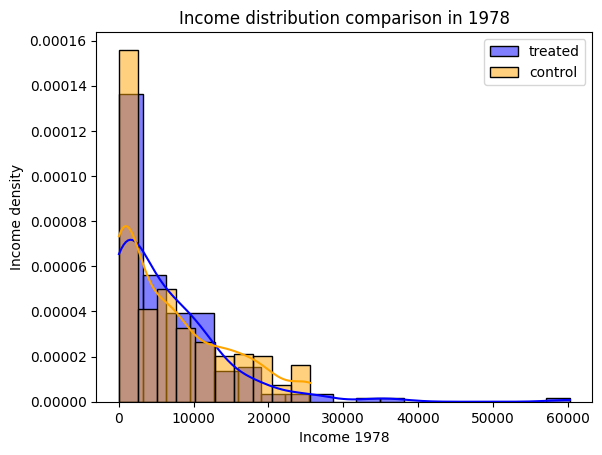

In [15]:
''' your code and explanations '''
treated = df.loc[df['treat'] == 1] #People that attained the programme
control = df.loc[df['treat'] == 0] #People that didn't attain the programme

print("Treated:")
print(treated.re78.describe())
print("\n")
print("---------------------------------")
print("\n")
print("Control:")
print(control.re78.describe())

ax = sns.histplot(treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend();

The treated group has:

1. lower mean earnings value
2. higher first (25%) percentile - low income interval (though)
3. Some outliers of really high income rates - with maximum income

The control group has:
1. higher mean earnings value
2. higher percentile (50%,75%)
3. higher number of people with income in the interval 12000 - 27000

We conclude that, in general, the control group outperforms the treated one in most of the cases.

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

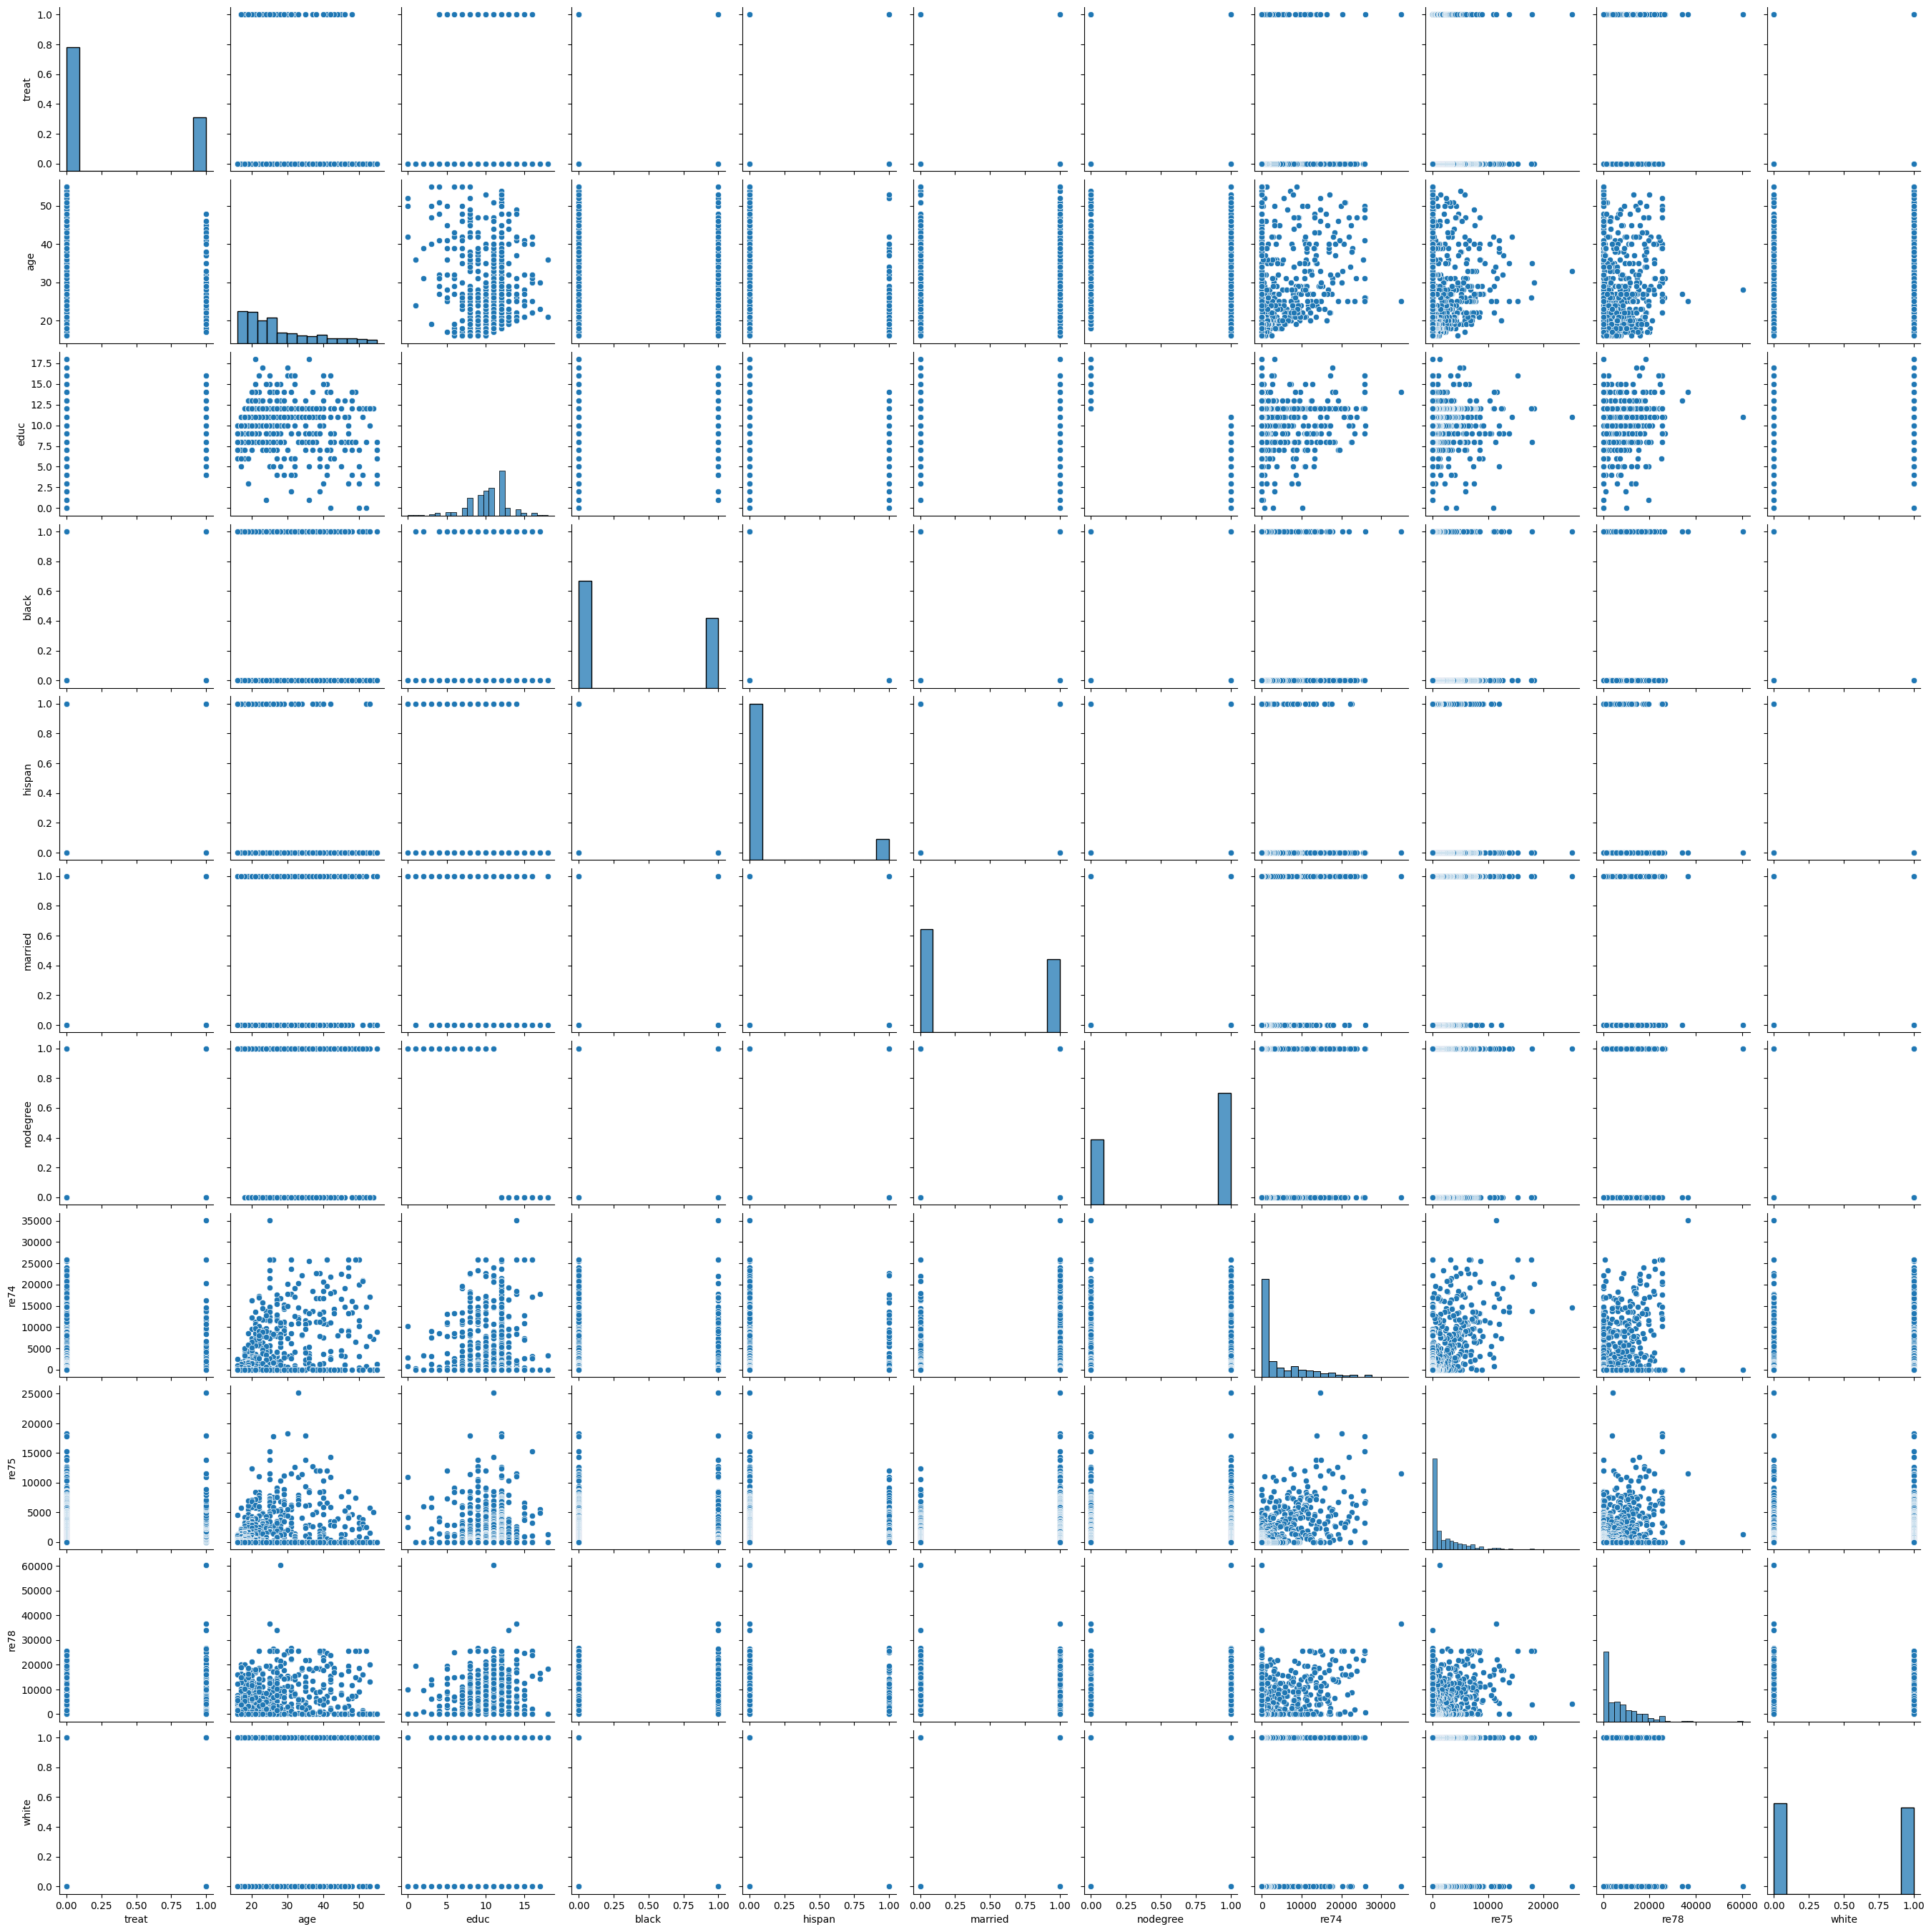

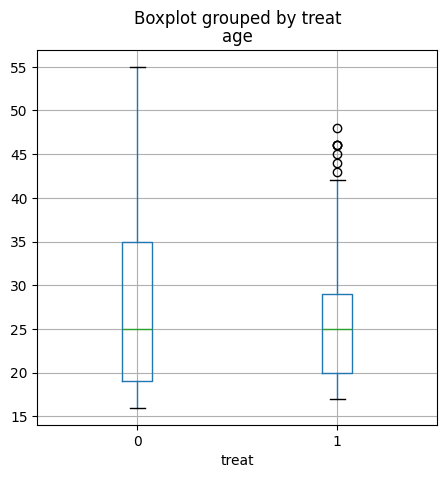

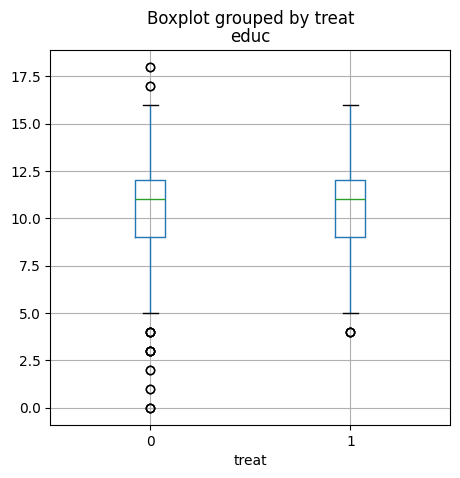

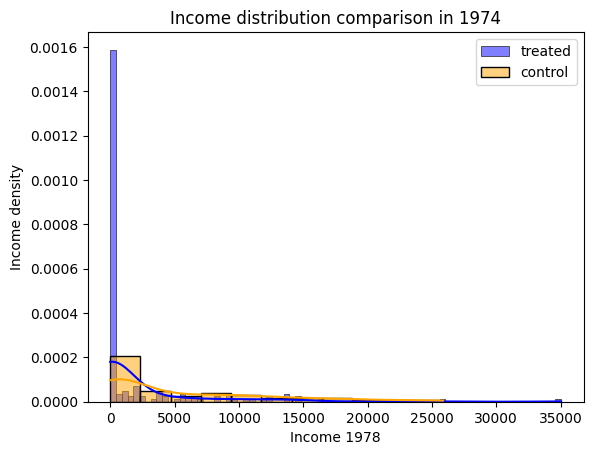

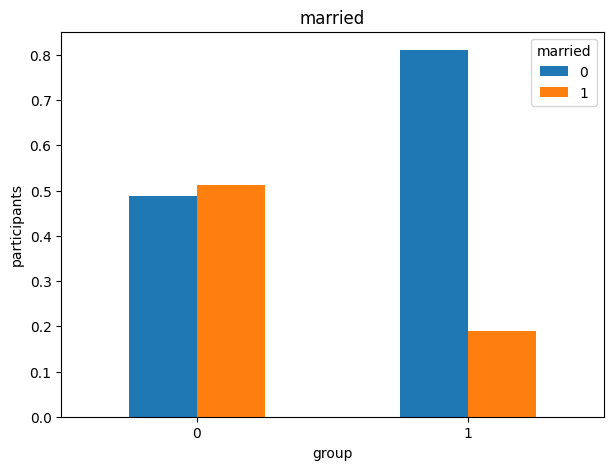

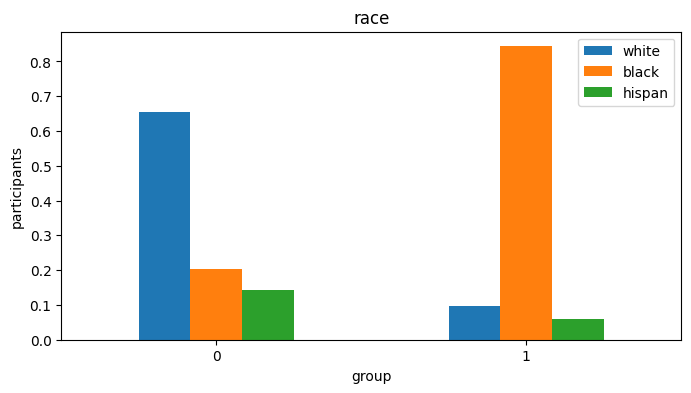

In [21]:
''' your code and explanations '''
sns.pairplot(df)
plt.show()

# Age -- quite different, the members of the treated tend to be younger than the ones in the control group
df.boxplot(by='treat', column='age', figsize = [5, 5], grid=True)
plt.show()

# education
df.boxplot(by='treat', column='educ', figsize = [5, 5], grid=True)
plt.show()

# income in the previous year
ax = sns.histplot(treated['re74'], stat='density', kde=True, color='blue', label='treated');
ax = sns.histplot(control['re74'], stat='density', kde=True, color='orange', label='control')
ax.set(title='Income distribution comparison in 1974',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()
# As we can observe from the income plot, the number of treated members that were unemployed before the training program is quite high. 
# So this might give us an intuition of how much the program helped people to find a job, independently of the income that they got eventually. 

# marriage
group = df.groupby(['treat', 'married'])['married'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[7,5], rot=0)
pl.set_title('married')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()
# The percentage of unmarried people between the treated group is much higher than the married ones whereas in the control group, the two categories are balanced. 
# This might be an indication of what type of people are included in the program.

# race
df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(bool)
lalonde_data_group = df.groupby(df.treat)[['white', 'black', 'hispan']].sum()
lalonde_data_group = lalonde_data_group.div(lalonde_data_group.sum(axis=1), axis=0)
pl = lalonde_data_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('race')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show();
# white outnumber the other races in the control group, and on the other hand, in the treated group the proportion of black is almost the only one

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [25]:
''' your code and explanations '''
# standardize the continuous features
df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
df['educ'] = (df['educ'] - df['educ'].mean())/df['educ'].std()
df['re74'] = (df['re74'] - df['re74'].mean())/df['re74'].std()
df['re75'] = (df['re75'] - df['re75'].mean())/df['re75'].std()

mod = smf.logit(formula='treat ~  age + educ + C(black) + C(hispan)  + C(married) + C(nodegree) +re74 + re75', data=df)
res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                  0.3508
Time:                        18:17:17   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

Matched Treated Group:
count      185.000000
mean      5935.862934
std       6682.551689
min          0.000000
25%         94.574500
50%       3983.951000
75%       9088.018000
max      36646.950000
Name: re78, dtype: float64

Matched Control Group:
count      185.000000
mean      5868.056646
std       7376.275997
min          0.000000
25%          0.000000
50%       3873.121000
75%       8923.991000
max      60307.930000
Name: re78, dtype: float64


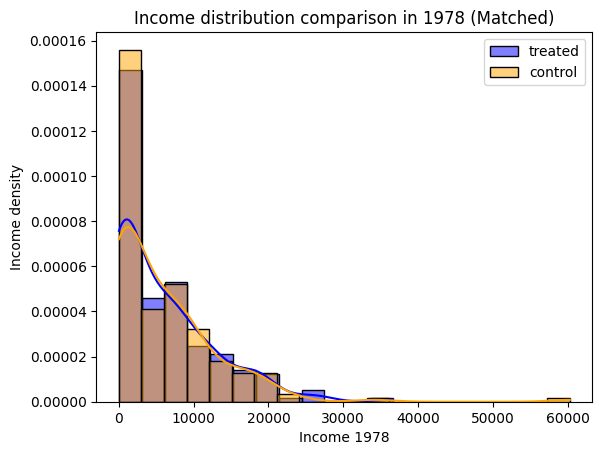

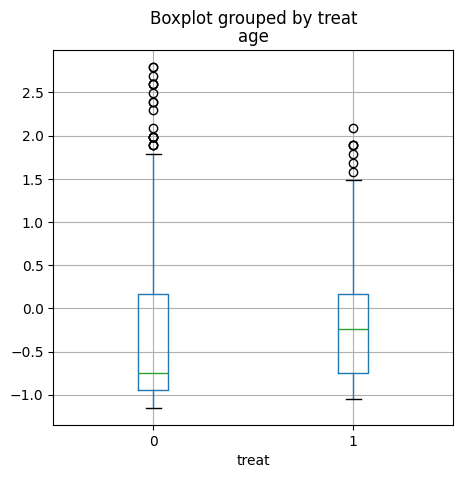

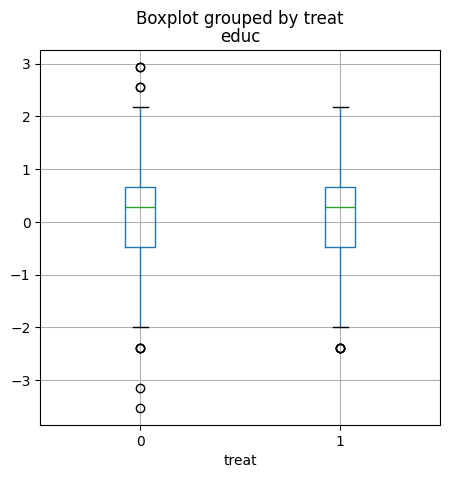

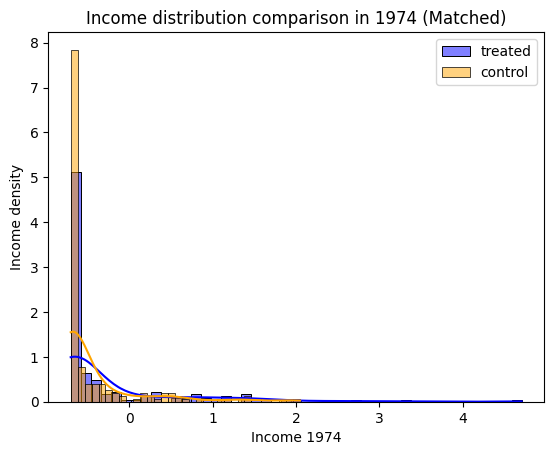

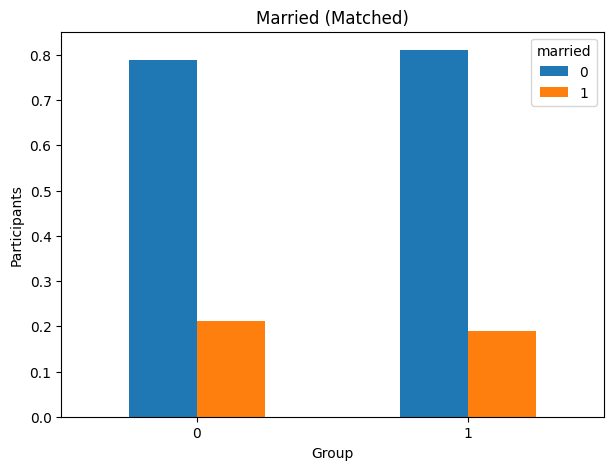

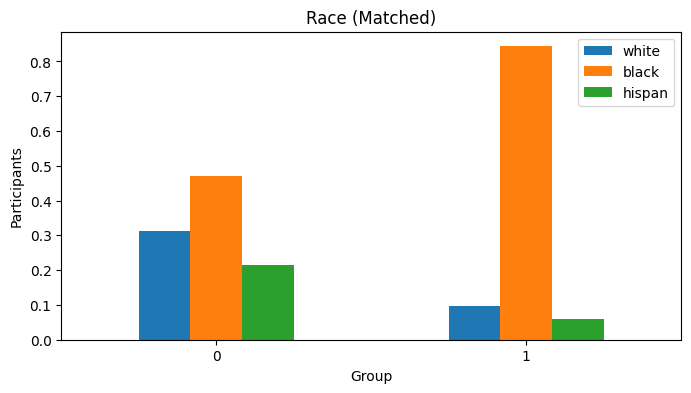

In [36]:
''' your code and explanations '''
G = nx.Graph()

# Separate the treatment and control groups
treatment_df = df[df['treat'] == 1]
control_df = df[df['treat'] == 0]

# Add edges with weights as the negative absolute difference of propensity scores
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():
        similarity = 1 - np.abs(control_row['Propensity_score'] - treatment_row['Propensity_score'])
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# optimal matching
matching = nx.max_weight_matching(G, maxcardinality=True)

# Extract matched pairs
matched_treated_indices = [t for t, c in matching]
matched_control_indices = [c for t, c in matching]

matched_treated = df.loc[matched_treated_indices]
matched_control = df.loc[matched_control_indices]

# Compare the outcomes (re78) between the two groups
print("Matched Treated Group:")
print(matched_treated['re78'].describe())
print("\nMatched Control Group:")
print(matched_control['re78'].describe())

# Plot the income distribution comparison for matched groups
ax = sns.histplot(matched_treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(matched_control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978 (Matched)', xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

# Compare feature-value distributions between the two groups for matched subjects
# Age
df_matched = pd.concat([matched_treated, matched_control])
df_matched.boxplot(by='treat', column='age', figsize=[5, 5], grid=True)
plt.show()

# Education
df_matched.boxplot(by='treat', column='educ', figsize=[5, 5], grid=True)
plt.show()

# Income in the previous year
ax = sns.histplot(matched_treated['re74'], stat='density', kde=True, color='blue', label='treated')
ax = sns.histplot(matched_control['re74'], stat='density', kde=True, color='orange', label='control')
ax.set(title='Income distribution comparison in 1974 (Matched)', xlabel='Income 1974', ylabel='Income density')
plt.legend()
plt.show()

# Marriage
group_matched = df_matched.groupby(['treat', 'married'])['married'].count().unstack().div(df_matched.groupby(['treat', 'married'])['married'].count().unstack().sum(axis=1), axis=0)
pl = group_matched.plot(kind='bar', figsize=[7, 5], rot=0)
pl.set_title('Married (Matched)')
pl.set_ylabel('Participants')
pl.set_xlabel('Group')
plt.show()

# Race
df_matched['white'] = (~(df_matched['black'].astype(bool) | df_matched['hispan'].astype(bool))).astype(bool)
lalonde_data_group_matched = df_matched.groupby(df_matched.treat)[['white', 'black', 'hispan']].sum().div(df_matched.groupby(df_matched.treat)[['white', 'black', 'hispan']].sum().sum(axis=1), axis=0)
pl = lalonde_data_group_matched.plot(kind='bar', figsize=[8, 4], rot=0)
pl.set_title('Race (Matched)')
pl.set_ylabel('Participants')
pl.set_xlabel('Group')
plt.show()

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


Improved Matched Treated Group:
count      116.000000
mean      6578.789638
std       6919.142968
min          0.000000
25%        987.294825
50%       4731.107500
75%      10256.460000
max      36646.950000
Name: re78, dtype: float64

Improved Matched Control Group:
count      116.000000
mean      4892.404390
std       5708.440218
min          0.000000
25%          0.000000
50%       2256.488500
75%       8382.403750
max      19330.140000
Name: re78, dtype: float64


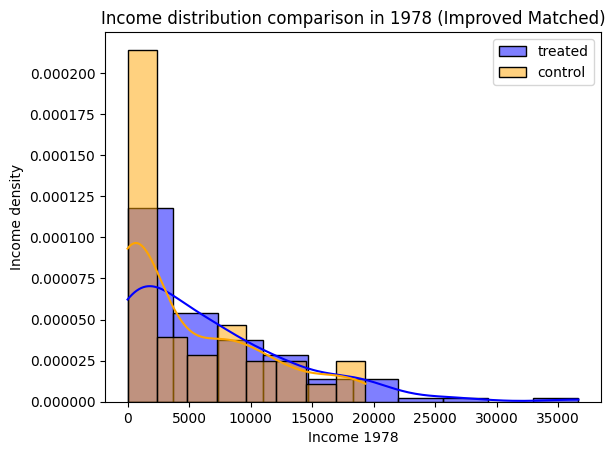

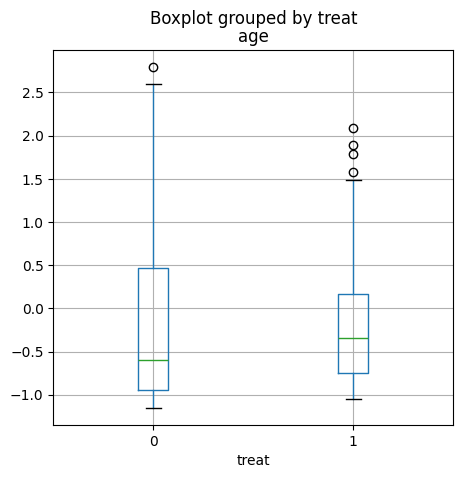

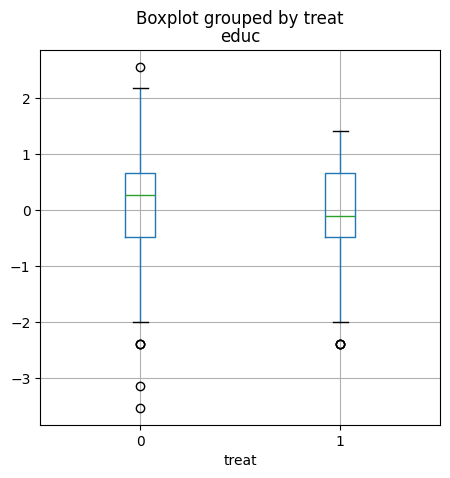

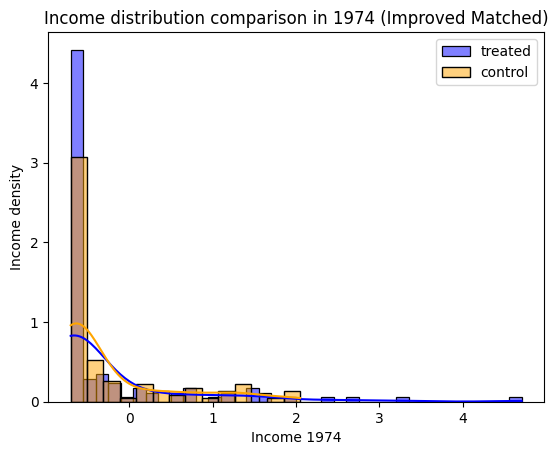

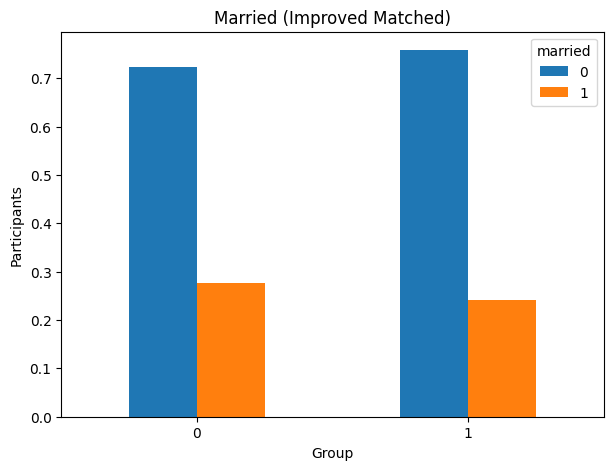

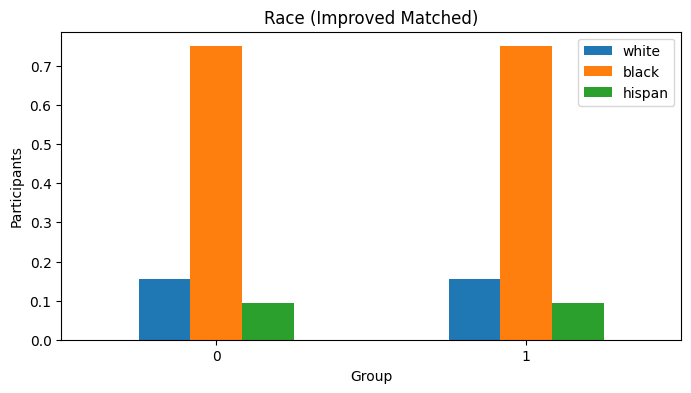

In [37]:
''' your code and explanations '''
# Improve matching by ensuring the same race
G_improved = nx.Graph()

# Add edges with weights as the negative absolute difference of propensity scores, but only for same race
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():
        if control_row['black'] == treatment_row['black'] and control_row['hispan'] == treatment_row['hispan']:
            similarity = 1 - np.abs(control_row['Propensity_score'] - treatment_row['Propensity_score'])
            G_improved.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Optimal matching
matching_improved = nx.max_weight_matching(G_improved, maxcardinality=True)

# Extract matched pairs
matched_treated_indices_improved = [t for t, c in matching_improved]
matched_control_indices_improved = [c for t, c in matching_improved]

matched_treated_improved = df.loc[matched_treated_indices_improved]
matched_control_improved = df.loc[matched_control_indices_improved]

# Compare the outcomes (re78) between the two groups
print("Improved Matched Treated Group:")
print(matched_treated_improved['re78'].describe())
print("\nImproved Matched Control Group:")
print(matched_control_improved['re78'].describe())

# Plot the income distribution comparison for improved matched groups
ax = sns.histplot(matched_treated_improved['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(matched_control_improved['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978 (Improved Matched)', xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

# Compare feature-value distributions between the two groups for improved matched subjects
# Age
df_matched_improved = pd.concat([matched_treated_improved, matched_control_improved])
df_matched_improved.boxplot(by='treat', column='age', figsize=[5, 5], grid=True)
plt.show()

# Education
df_matched_improved.boxplot(by='treat', column='educ', figsize=[5, 5], grid=True)
plt.show()

# Income in the previous year
ax = sns.histplot(matched_treated_improved['re74'], stat='density', kde=True, color='blue', label='treated')
ax = sns.histplot(matched_control_improved['re74'], stat='density', kde=True, color='orange', label='control')
ax.set(title='Income distribution comparison in 1974 (Improved Matched)', xlabel='Income 1974', ylabel='Income density')
plt.legend()
plt.show()

# Marriage
group_matched_improved = df_matched_improved.groupby(['treat', 'married'])['married'].count().unstack().div(df_matched_improved.groupby(['treat', 'married'])['married'].count().unstack().sum(axis=1), axis=0)
pl = group_matched_improved.plot(kind='bar', figsize=[7, 5], rot=0)
pl.set_title('Married (Improved Matched)')
pl.set_ylabel('Participants')
pl.set_xlabel('Group')
plt.show()

# Race
df_matched_improved['white'] = (~(df_matched_improved['black'].astype(bool) | df_matched_improved['hispan'].astype(bool))).astype(bool)
lalonde_data_group_matched_improved = df_matched_improved.groupby(df_matched_improved.treat)[['white', 'black', 'hispan']].sum().div(df_matched_improved.groupby(df_matched_improved.treat)[['white', 'black', 'hispan']].sum().sum(axis=1), axis=0)
pl = lalonde_data_group_matched_improved.plot(kind='bar', figsize=[8, 4], rot=0)
pl.set_title('Race (Improved Matched)')
pl.set_ylabel('Participants')
pl.set_xlabel('Group')
plt.show()

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

Improved Matched Treated Group:
count      116.000000
mean      6578.789638
std       6919.142968
min          0.000000
25%        987.294825
50%       4731.107500
75%      10256.460000
max      36646.950000
Name: re78, dtype: float64

Improved Matched Control Group:
count      116.000000
mean      4892.404390
std       5708.440218
min          0.000000
25%          0.000000
50%       2256.488500
75%       8382.403750
max      19330.140000
Name: re78, dtype: float64


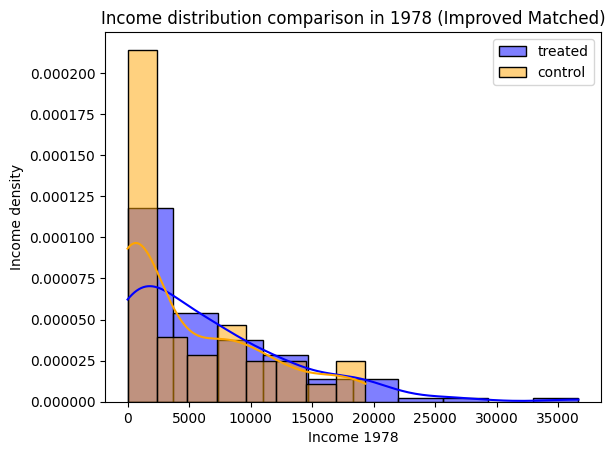

Mean income for treated group: 6578.789637931034
Mean income for control group: 4892.404390086207
The job training program appears to be effective, as the treated group has a higher mean income.


In [40]:
''' your code and explanations '''
# Compare the outcomes (re78) between treated and control subjects for the improved matched dataset
print("Improved Matched Treated Group:")
print(matched_treated_improved['re78'].describe())
print("\nImproved Matched Control Group:")
print(matched_control_improved['re78'].describe())

# Plot the income distribution comparison for improved matched groups
ax = sns.histplot(matched_treated_improved['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(matched_control_improved['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978 (Improved Matched)', xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

# Conclusion about the effectiveness of the job training program
treated_mean = matched_treated_improved['re78'].mean()
control_mean = matched_control_improved['re78'].mean()
print(f"Mean income for treated group: {treated_mean}")
print(f"Mean income for control group: {control_mean}")

if treated_mean > control_mean:
    print("The job training program appears to be effective, as the treated group has a higher mean income.")
else:
    print("The job training program does not appear to be effective, as the treated group does not have a higher mean income.")